<span style="color:#337AFF;font-size:20px;font-weight:bold;">PROBLEM  STATEMENT</span>

Driver distraction is a significant and over-arching problem with many dimensions. Distracted Driving involves any activity a person engages in, that has the potential to distract him or her from the primary task of driving and increase the risk of a crash. The need to address this issue and implement effective countermeasures is urgent to improve public safety.

![DriverUrl](https://kaggle2.blob.core.windows.net/competitions/kaggle/5048/media/output_DEb8oT.gif "driver")

<span style="color:#337AFF;font-size:20px;font-weight:bold;">SOLUTION</span>

By leveraging deep learning techniques, 

1. To develop an accurate and robust system for detecting distracted driver and warn them against it. 
2. To classify the cause of distraction which will help initiate appropriate follow up actions.
3. To use transfer learning technique to predict the probability for one of each class below, for an input image.

        c0: normal driving 
        c1: texting – right 
        c2: talking on the phone – right
        c3: texting - left 
        c4: talking on the phone - left 
        c5: operating the radio 
        c6: drinking 
        c7: reaching behind 
        c8: hair and makeup 
        c9: talking to passenger

In [337]:
import warnings
warnings.filterwarnings('ignore')

In [338]:
import os
from IPython import display
import time
import shutil
import logging
import datetime
import json
from numpy import array

In [339]:
import numpy as np
import pandas as pd

In [340]:
import matplotlib.pyplot as plt
%matplotlib inline

In [341]:
from PIL import Image
from keras.models import model_from_json

In [342]:
logging.basicConfig(filename='AlexNetSavedPretrained.log',level=logging.DEBUG)
ts = datetime.datetime.now()
logging.info("******************************************************************")
logging.info("Execution started at - "+ts.strftime("%Y-%m-%d %H:%M:%S"))

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Custom functions</span>

In [343]:
def fun_SetWorkingDirectoryPath(directoryPath):
    os.chdir(directoryPath)

In [344]:
def fun_DeleteWorkingDirectory(working_dir_path):
    if os.path.exists(working_dir_path):
        shutil.rmtree(working_dir_path)
        logging.info("Deleted Working Directory")
        print("Deleted Working Directory Successfully !")
    else:
        logging.error("Directory Doesn't Exist")
        print("Directory Doesn't Exist !")
    print("")

In [345]:
def fun_CreateWorkingDirectories(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(directory + "  -  Created !")
        print(directory + "  -  Created !")
    print("")

In [346]:
def fun_GetFilesList(directoryPath):
    files_list = []
    for root, directories, filenames in os.walk(directoryPath):
        for filename in filenames:
            iterImage = filename.upper()
            if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
                files_list.append(os.path.join(root,filename))
    
    return(files_list)

In [347]:
def fun_ConvertImagesToArray(readFile, imageFilesList):
    imageFileArray = []
    filesReadCount = 0
    #for tempImages in imageFilesList:
    logging.debug("Reading {0} images :".format(readFile))
    print("Reading {0} images :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            tempArray = np.array(Image.open(tempImages))
            if (len(tempArray.shape))==2:
                tempShape = tempArray.shape
                tempArray = tempArray.reshape(tempShape[0], tempShape[1], 1)
            imageFileArray.append(tempArray)
            filesReadCount = filesReadCount + 1
    print("")
        
    return(np.asarray(imageFileArray))

In [348]:
def fun_GetLabelsFromFileNames(entire_images_list):
    Y_Master = []
    for image_name in entire_images_list:
        try:
            temp = image_name.split("/")
            Y_Master.append(int(temp[len(temp)-2][1]))
        except:
            continue
    return(Y_Master)

In [349]:
def fun_ConvertImages(readFile, imageFilesList, resizeHeight=None, resizeWidth=None, isGrayScaledConversion=None):
    imageFileArray = []
    filesReadCount = 0
    logging.debug("Converting {0} to the desired format :".format(readFile))
    print("Converting {0} to the desired format :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            image=Image.open(tempImages)
            
            if (resizeHeight is not None and resizeWidth is not None):
                image = image.resize((resizeHeight, resizeWidth))

            if (isGrayScaledConversion):
                image=image.convert('L')

            temp = tempImages.replace("Complete Dataset", "Working Dir")
            image.save(temp)
            imageFileArray.append(temp)
            filesReadCount = filesReadCount + 1
            
    return (readFile, imageFileArray)

In [350]:
def fun_Delete_And_Create_Working_Dir(working_dir_path):
    fun_DeleteWorkingDirectory(working_dir_path)
    for i in range(0,10):
        fun_CreateWorkingDirectories(working_dir_path + "imgs/train/c" + str(i))

In [351]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [352]:
def fun_oneHotEncode(labels):
    values = array(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    values=values.reshape(len(values), 1)
    onehot_encoded = to_categorical(values)
    return onehot_encoded

In [353]:
def save_model(working_dir_path, model, index, cross=''):
    print(model)
    json_string = model.to_json()
    if not os.path.isdir(working_dir_path + '/cache'):
        os.mkdir(working_dir_path + '/cache')
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    open(os.path.join(working_dir_path + '/cache', json_name), 'w').write(json_string)
    print(working_dir_path + '/cache')
    model.save_weights(os.path.join(working_dir_path + '/cache', weight_name), overwrite=True)

In [354]:
def read_model(working_dir_path, index, cross=''):
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    model = model_from_json(open(os.path.join(working_dir_path + '/cache', json_name)).read())
    model.load_weights(os.path.join(working_dir_path + '/cache', weight_name),by_name=True)
    return model

In [355]:
def fun_AlexNet_model():
    model = Sequential()
    
    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),\
                     strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())
    
    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())
    
    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    #model.add(Dense(10))
    #model.add(Activation('softmax'))

    return model

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Loading input Data</span>

In [356]:
source_dir_path = "/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/"

In [357]:
working_dir_path = "/mnt/home/kumar.manjushree_gmail/Capstone/WorkingDir/"

In [358]:
source_dir_path

'/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/'

In [359]:
## List of images
entire_images_list = fun_GetFilesList(source_dir_path)
print(source_dir_path)
logging.debug("(entire_images_list) :".format(len(entire_images_list)))
print("(entire_images_list) :", len(entire_images_list))

/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/
(entire_images_list) : 22424


In [360]:
## List of labels
entire_labels_list = fun_GetLabelsFromFileNames(entire_images_list)
logging.debug("(entire_labels_list) :".format(len(entire_labels_list)))
print("(entire_labels_list) :", len(entire_labels_list))

(entire_labels_list) : 22424


In [361]:
## Data frame of training set    
filePath_Labels_List_df = pd.DataFrame(
                                        {
                                            'Files_Path': entire_images_list,
                                            'Labels'    : entire_labels_list
                                        }
)

In [362]:
## Stratified sample
train_test_filePath_Labels_List_df = filePath_Labels_List_df.sample(n=3000, random_state=10)

In [363]:
num_classes=10

In [364]:
## Shuffling images in sample
for i in range(num_classes):
    logging.debug("(Label, Number of Rows) : ({0}, {1})".format(i, len(
        train_test_filePath_Labels_List_df[train_test_filePath_Labels_List_df["Labels"]==i])))
    print("(Label, Number of Rows) : ({0}, {1})".format(i, len(
        train_test_filePath_Labels_List_df[train_test_filePath_Labels_List_df["Labels"]==i])))
    print("")
    train_test_filePath_Labels_List_df_shuffled = train_test_filePath_Labels_List_df.reindex(
        np.random.permutation(train_test_filePath_Labels_List_df.index))


(Label, Number of Rows) : (0, 350)

(Label, Number of Rows) : (1, 297)

(Label, Number of Rows) : (2, 314)

(Label, Number of Rows) : (3, 310)

(Label, Number of Rows) : (4, 297)

(Label, Number of Rows) : (5, 335)

(Label, Number of Rows) : (6, 277)

(Label, Number of Rows) : (7, 266)

(Label, Number of Rows) : (8, 246)

(Label, Number of Rows) : (9, 308)



In [365]:
train_test_filePath_Labels_List_df_shuffled.head(10)

,Files_Path,Labels
13302,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c3/img_18969.jpg,3
14475,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c3/img_64603.jpg,3
1773,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c9/img_84563.jpg,9
8221,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c6/img_94078.jpg,6
6156,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c6/img_11817.jpg,6
909,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c9/img_47403.jpg,9
8750,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c5/img_23348.jpg,5
13297,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c3/img_18841.jpg,3
13869,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c3/img_40777.jpg,3
21229,/mnt/home/kumar.manjushree_gmail/Capstone/imgs/train/c0/img_56098.jpg,0


<span style="color:#337AFF;font-size:18px;font-weight:bold;">Splitting and preprocessing</span>

In [366]:
## Split into train and test
X_train, X_test, Y_train, Y_test = (train_test_split(
                                                train_test_filePath_Labels_List_df_shuffled["Files_Path"], 
                                                train_test_filePath_Labels_List_df_shuffled["Labels"], 
                                                test_size = 0.3,
                                                random_state = 10
                                            )
                                   )
logging.debug("(X_train, Y_train) : ({0}, {1})".format(len(X_train), len(Y_train)))
print("(X_train, Y_train) : ({0}, {1})", len(X_train), len(Y_train))
logging.debug("(X_test, Y_test)   : ({0}, {1})".format(len(X_test), len(Y_test)))
print("(X_test, Y_test)   : ({0}, {1})", len(X_test), len(Y_test))
print("")

(X_train, Y_train) : ({0}, {1}) 2100 2100
(X_test, Y_test)   : ({0}, {1}) 900 900



In [367]:
Y_test.shape

(900,)

In [368]:
## Resize test images
(readFile, imageFileArray) = fun_ConvertImages(
                        readFile="X_test",
                        imageFilesList=X_test, 
                        resizeHeight=224, 
                        resizeWidth=224, 
                        isGrayScaledConversion=False
                )

Converting X_test to the desired format :


A Jupyter Widget

In [369]:
## Convert test images to Array
X_test  = fun_ConvertImagesToArray(
                       readFile,
                       imageFileArray
                  )
        
X_test = X_test.astype('float32') 
#Y_test = Y_test.astype('float32')

Reading X_test images :


A Jupyter Widget

In [370]:
# Normalise data to [0, 1] range
X_test /= np.max(X_test)
#Y_test /= np.max(Y_test)
logging.debug("(X_test.shape, Y_test.shape) : ({0}, {1})".format(X_test.shape, Y_test.shape))
print("(X_test.shape, Y_test.shape) : ({0}, {1})".format(X_test.shape, Y_test.shape))    

(X_test.shape, Y_test.shape) : ((900, 224, 224, 3), (900,))


In [371]:
# One-hot encode the test labels
Y_test = fun_oneHotEncode(Y_test)

In [372]:
## Prepare input
img_rows, img_cols, img_channel = 224, 224, 3
img_shape=(img_rows, img_cols, img_channel)

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Loading Saved Models</span>

AlexNet model, pretrained with "imageNet" has been used and retrained with images specific to the problem statement. This model has been trained with 3000 images belonging to various classes.

In [373]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.applications.mobilenet import MobileNet

In [374]:
loss="categorical_crossentropy"
optimizer="adam"
metrics="accuracy"
batch_size = 32
num_epochs = 20
validation_split=0.2
estimators=[]

In [375]:
alexnetmodel =  read_model("/mnt/home/kumar.manjushree_gmail/Capstone/", 0, 'alexnet')

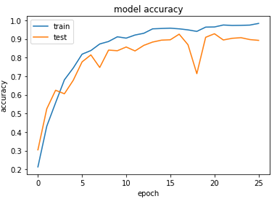

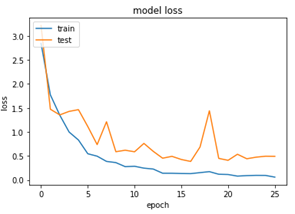

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Confusion Matrices and Predictions</span>

In [376]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [377]:
import scikitplot as skplt

In [378]:
model_name = "alexnetPredictions"
extension = '.npy'
prediction_path = './predictions/' + model_name + extension

In [379]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix

In [380]:

# Predict the values from the validation dataset
Y_pred = alexnetmodel.predict(X_test)
np.save(prediction_path, Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 

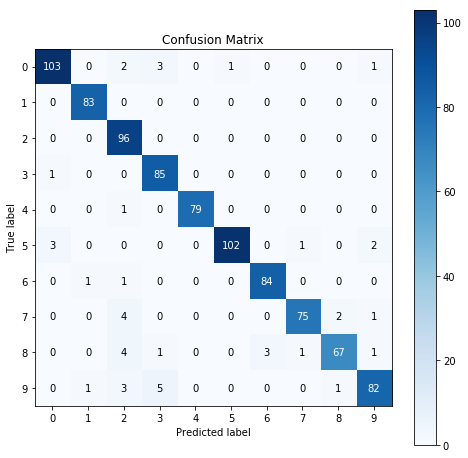

In [381]:
skplt.metrics.plot_confusion_matrix(Y_true, Y_pred_classes, figsize=(8,8))

In [382]:
# Predict
test_acc = round(accuracy_score(Y_test, Y_pred.round())*100)
print("Test accuracy:", test_acc)

resultList = []
classType = []
for i in range(len(X_test)):
    preds = Y_pred[i]
    #print("Predictions", i, preds.round())
    #print("Labels", i, Y_test[i])
    if (np.argmax(preds.round()) == np.argmax(Y_test[i])):
        resultList.append("right")
        classType.append(np.argmax(Y_test[i]))
    else:
        resultList.append("wrong")
        classType.append(np.argmax(Y_test[i]))

Test accuracy: 95.0


In [383]:
class_df = pd.DataFrame(
                            {
                                'Class': classType,
                                'Labels': Y_test[:,0],
                                'Predictions'    : Y_pred[:,0],
                                'Result': resultList
                            }
    )

In [384]:
class_df.head(5)

,Class,Labels,Predictions,Result
0,9,0.0,2.049447e-03,right
1,9,0.0,5.540781e-08,right
2,0,1.0,9.997987e-01,right
3,2,0.0,3.493090e-13,right
4,5,0.0,1.820315e-07,right


In [385]:
groupedClassResult = pd.DataFrame({'count' : class_df.groupby( [ "Class", "Result"] ).size()}).reset_index()
groupedClassResult.shape
groupedClass = pd.DataFrame({'count' : class_df.groupby( [ "Class"] ).size()}).reset_index()
groupedClass.shape
merged_inner = pd.merge(left=groupedClass,right=groupedClassResult, left_on='Class', right_on='Class')
merged_inner.columns = ['Class', 'TotalCount', 'Result', 'ResultCount']

In [386]:
merged_df = merged_inner.pivot_table('ResultCount', ['Class', 'TotalCount'], 'Result').fillna(0)
merged_df['RightPrediction%'] = (merged_df['right']/(merged_df['right']+merged_df['wrong']))*100
merged_df

,Result,right,wrong,RightPrediction%
Class,TotalCount,,,
0,110,105.0,5.0,95.454545
1,83,83.0,0.0,100.000000
2,96,96.0,0.0,100.000000
3,86,85.0,1.0,98.837209
4,80,79.0,1.0,98.750000
5,108,102.0,6.0,94.444444
6,86,84.0,2.0,97.674419
7,82,75.0,7.0,91.463415
8,77,66.0,11.0,85.714286


<span style="color:#337AFF;font-size:18px;font-weight:bold;">Predicting class of images</span>

In [387]:
## List of images to predict
input_images_list = fun_GetFilesList("/mnt/home/kumar.manjushree_gmail/Capstone/predict")
logging.debug("(input_images_list) :".format(len(input_images_list)))
print("(input_images_list) :", len(input_images_list))

(input_images_list) : 8


In [388]:
(readFile, imageFileArray) = fun_ConvertImages(
                            readFile="Predict_Images",
                            imageFilesList=input_images_list, 
                            resizeHeight=224, 
                            resizeWidth=224, 
                            isGrayScaledConversion=False
                    )
    

Converting Predict_Images to the desired format :


A Jupyter Widget

In [389]:
## Convert train images to Array
input_images = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
input_images = input_images.astype('float32') 

Reading Predict_Images images :


A Jupyter Widget

In [390]:
# Normalise data to [0, 1] range
input_images /= np.max(input_images)
    
logging.debug("(input_images) : ({0})".format(input_images.shape))
print("(input_images) : ({0})".format(input_images.shape))

(input_images) : ((8, 224, 224, 3))


In [391]:
predict_classes = alexnetmodel.predict(input_images, batch_size=5, verbose=1)

8/8 [==============================] - 0s 22ms/step


In [392]:
def classValue(x):
    return {
        0: "Normal Driving",
        1: "Texting - right",
        2: "Talking on the phone - right",
        3: "Texting - left",
        4: "Talking on the phone - left",
        5: "Operating the radio",
        6: "Drinking",
        7: "Reaching behind",
        8: "Hair and makeup",
        9: "Talking to passenger"
    }[x]

In [393]:
vals=[]
classNames=[]
for val in predict_classes:
    #print(np.argmax(val))
    vals.append(np.argmax(val))
    classNames.append(classValue(np.argmax(val)))

In [394]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64

In [395]:
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [396]:
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [397]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

In [398]:
predictions = pd.DataFrame(
                            {
                                'id':range(0,8),
                                'Image': input_images_list,
                                'Label': vals,
                                'Description': classNames
                            }
    )

predictions['dispimage'] = predictions.Image.map(lambda f: get_thumbnail(f))

In [399]:
pd.set_option('display.max_colwidth', -1)

,dispimage,Label,Description
0,,5,Operating the radio
1,,5,Operating the radio
2,,3,Texting - left
3,,3,Texting - left
4,,2,Talking on the phone - right
5,,8,Hair and makeup
6,,2,Talking on the phone - right
7,,5,Operating the radio

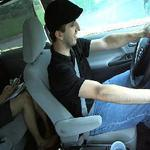
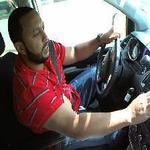
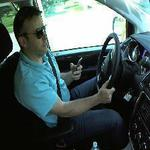
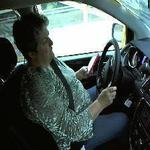
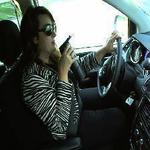
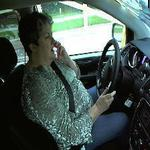
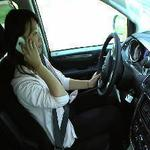
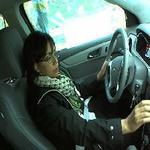

In [400]:
# displaying PIL.Image objects embedded in dataframe
HTML(predictions[['dispimage', 'Label', 'Description']].to_html(formatters={'dispimage': image_formatter}, escape=False))

In [401]:
te = datetime.datetime.now()
logging.info("Execution ended at - " + te.strftime("%Y-%m-%d %H:%M:%S"))
timetaken=te-ts

In [402]:
logging.info("Total time taken - " + str(timetaken))